In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, split, array_contains
import time
import pandas as pd

chunk_amounts = [50, 600, 3844]
iterations = 5
executor_cores_options = [1, 2]

# Prepare to collect results
results = []

for executor_cores in executor_cores_options:
    spark_session = SparkSession.builder\
        .appName("DF")\
        .master("spark://192.168.2.174:7077")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled", True)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout", "30000s")\
        .config("spark.executor.cores", executor_cores)\
        .config("spark.driver.port", 9999)\
        .config("spark.blockManager.port", 10005)\
        .config("spark.executor.memory", "2g")\
        .getOrCreate()

    for chunks in chunk_amounts:
        for iteration in range(iterations):
            start_time = time.time()

            file_paths = [f"hdfs://master:9000/path/in/hdfs/JsonFiles/corpus-webis-shortened_chunk{i}.json" for i in range(1, chunks + 1)]
            df = spark_session.read.option("multiline", "true").json(file_paths)

            mid_time = time.time()

            # Use Spark SQL functions to find posts containing 'sleep'
            df_with_sleep = df.filter(array_contains(split(lower(col("content")), " "), "sleep"))
            num_posts_with_sleep = df_with_sleep.count()

            end_time = time.time()

            load_time = mid_time - start_time
            total_time = end_time - start_time

            results.append({
                'Executor Cores': executor_cores,
                'Chunks': chunks,
                'Iteration': iteration + 1,
                'Load Time (s)': load_time,
                'Total Time (s)': total_time,
                'Posts with "sleep"': num_posts_with_sleep
            })
    
    spark_session.stop()

# Convert results to a pandas DataFrame for easy tabular display
results_df = pd.DataFrame(results)
print(results_df)





Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/08 19:17:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/03/08 19:27:33 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources


    Executor Cores  Chunks  Iteration  Load Time (s)  Total Time (s)  \
0                1      50          1      11.783069       15.048562   
1                1      50          2       1.749027        2.435902   
2                1      50          3       1.553926        2.088400   
3                1      50          4       1.548997        2.099507   
4                1      50          5       1.293335        1.901374   
5                1     600          1       8.697745       11.623706   
6                1     600          2       8.448431       11.010771   
7                1     600          3       7.657457       10.127264   
8                1     600          4       7.776933       10.251468   
9                1     600          5       7.453696        9.909385   
10               1    3844          1      81.956258      123.303258   
11               1    3844          2      75.319798      117.267157   
12               1    3844          3      54.697870       82.41

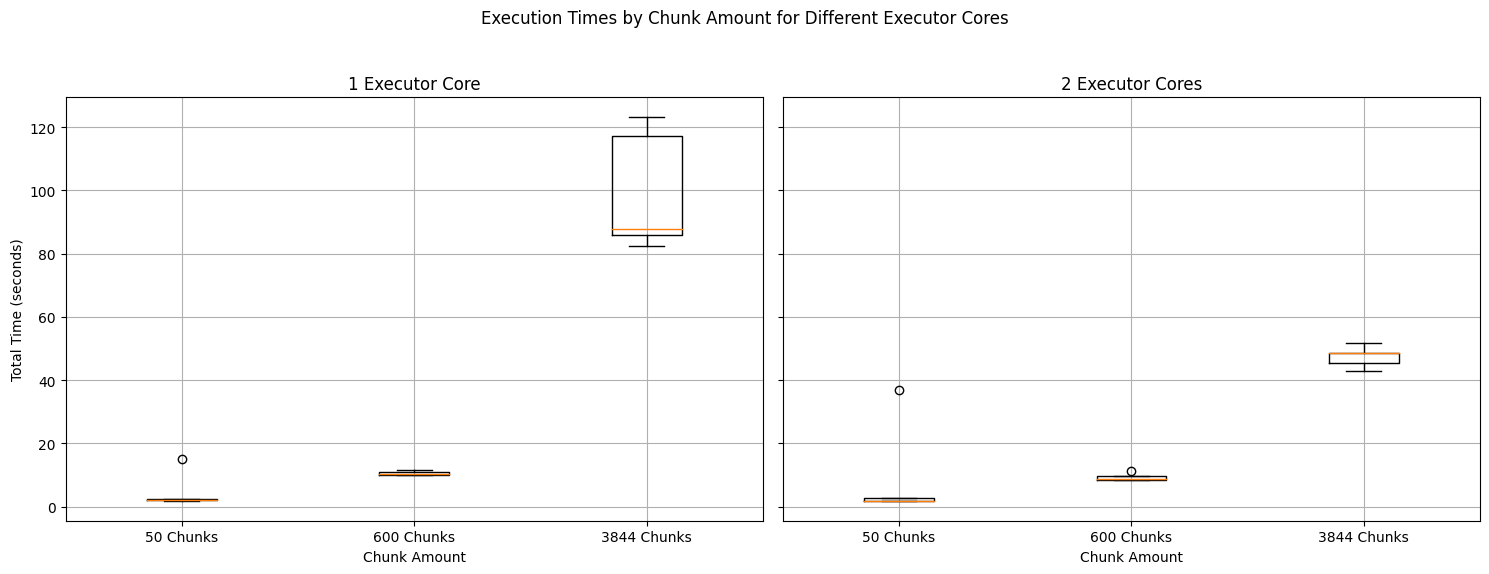

In [2]:
try:
    import matplotlib.pyplot as plt
    
    # Set up the figure and axes for the two plots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharey=True)
    
    # Title for the entire figure
    fig.suptitle('Execution Times by Chunk Amount for Different Executor Cores')
    
    # Plot settings for 1 executor core
    data_1_core = [results_df[(results_df['Executor Cores'] == 1) & (results_df['Chunks'] == chunks)]['Total Time (s)'] for chunks in chunk_amounts]
    axes[0].boxplot(data_1_core, labels=[f'{chunks} Chunks' for chunks in chunk_amounts])
    axes[0].set_title('1 Executor Core')
    axes[0].set_xlabel('Chunk Amount')
    axes[0].set_ylabel('Total Time (seconds)')
    axes[0].grid(True)
    
    # Plot settings for 2 executor cores
    data_2_cores = [results_df[(results_df['Executor Cores'] == 2) & (results_df['Chunks'] == chunks)]['Total Time (s)'] for chunks in chunk_amounts]
    axes[1].boxplot(data_2_cores, labels=[f'{chunks} Chunks' for chunks in chunk_amounts])
    axes[1].set_title('2 Executor Cores')
    axes[1].set_xlabel('Chunk Amount')
    axes[1].grid(True)
    
    # Use the same y-axis scale for both plots
    plt.yscale('linear')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust the layout to make room for the global title
    plt.show()

    

except ImportError:
    print("matplotlib is not installed. Install it via pip to enable plotting.")

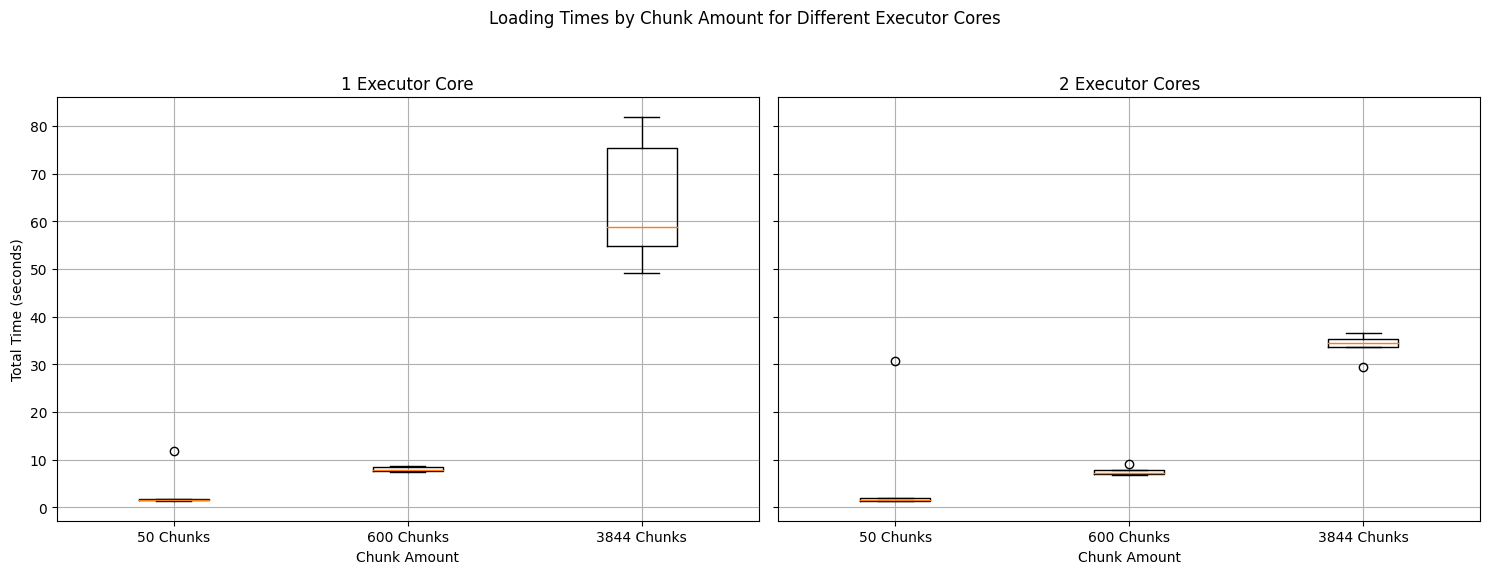

In [3]:
try:
    import matplotlib.pyplot as plt
    
    # Set up the figure and axes for the two plots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharey=True)
    
    # Title for the entire figure
    fig.suptitle('Loading Times by Chunk Amount for Different Executor Cores')
    
    # Plot settings for 1 executor core
    data_1_core = [results_df[(results_df['Executor Cores'] == 1) & (results_df['Chunks'] == chunks)]['Load Time (s)'] for chunks in chunk_amounts]
    axes[0].boxplot(data_1_core, labels=[f'{chunks} Chunks' for chunks in chunk_amounts])
    axes[0].set_title('1 Executor Core')
    axes[0].set_xlabel('Chunk Amount')
    axes[0].set_ylabel('Total Time (seconds)')
    axes[0].grid(True)
    
    # Plot settings for 2 executor cores
    data_2_cores = [results_df[(results_df['Executor Cores'] == 2) & (results_df['Chunks'] == chunks)]['Load Time (s)'] for chunks in chunk_amounts]
    axes[1].boxplot(data_2_cores, labels=[f'{chunks} Chunks' for chunks in chunk_amounts])
    axes[1].set_title('2 Executor Cores')
    axes[1].set_xlabel('Chunk Amount')
    axes[1].grid(True)
    
    # Use the same y-axis scale for both plots
    plt.yscale('linear')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust the layout to make room for the global title
    plt.show()

    

except ImportError:
    print("matplotlib is not installed. Install it via pip to enable plotting.")